# Online DA: Perfect pseudo experiments validation: 
Katie Brennan  
January 27, 2022  

In [2]:
import sys
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs

import pickle 

In [3]:
sys.path.append("../")
import Online_DA_utils as oda

In [4]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")

import LIM_utils_kb as limkb
import LIM_stats_kb as statskb
# import LIM_plot_kb as plotkb
import LIM_building as limbuild

In [5]:
import importlib
importlib.reload(oda)

<module 'Online_DA_utils' from '../Online_DA_utils.py'>

In [6]:
limvars = ['tas','tos','psl','zg','sit','sic']

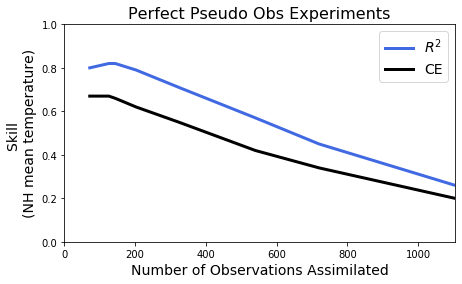

In [239]:
fig = plt.figure(figsize=(7,4))
nobs_tested = [72,126,144,203,324,540,720,1104]
tas_cor = [0.8,0.82,0.82,0.79,0.71,0.57,0.45,0.26]
tas_ce = [0.67,0.67,0.66,0.62,0.55,0.42,0.34,0.2]

plt.plot(nobs_tested, tas_cor, color='royalblue', label='$R^2$', linewidth=3)
plt.plot(nobs_tested, tas_ce, color='k', label='CE', linewidth=3)

plt.xlabel('Number of Observations Assimilated', fontsize=14)
plt.ylabel('Skill \n(NH mean temperature)', fontsize=14)
plt.title('Perfect Pseudo Obs Experiments', fontsize=16)

plt.ylim(0,1)
plt.xlim(0,1104)
plt.legend(fontsize=14)

## Load experiment: 

In [275]:
output_dir = '/home/disk/kalman2/mkb22/Online_DA/experiments/pseudo/'

#timename = 'Time_'+str(t)+'.pkl'
#filename = 'ODA_pseudo_perfect_cesm_lme_Amon_t_0_1860.pkl'
#filename = 'ODA_pseudo_perfect_cesm_lme_Amon_t_0_1860_noloopupdatePb.pkl'
#filename = 'ODA_pseudo_perfect_cesm_lme_Amon_t_0_1860_noloopupdatePb_1e3.pkl'
#filename = 'ODA_pseudo_perfect_cesm_lme_Amon_t_0_1860_nomj.pkl'
#filename = 'ODA_pseudo_perfect_cesm_lme_Amon_t_0_1860_nomj_trainR.pkl'
#filename = 'ODA_pseudo_perfect_cesm_lme_Amon_t_0_1860_nomj_trainRe.pkl'
#filename = 'ODA_pseudo_perfect_cesm_lme_Amon_t_0_1860_dlat19_dlon20_nomj_trainRe.pkl'
filename = 'ODA_perfect_pseudo_prior_cesm_lme_Amon_LIM_cesm_lme_Amon_obs_cesm_lme_Amon_hadCRUT_locations_t150_t_0_1860_nomj_trainRe.pkl'
#filename = 'ODA_pseudo_perfect_cesm_lme_Amon_t_0_1860_nomj_trainR.pkl'
#filename = 'ODA_pseudo_perfect_cesm_lme_Amon_t_0_1860_nomj_Re.pkl'

In [276]:
data = pickle.load(open(output_dir+filename,"rb"))

In [228]:
data['obs_assimilated'][0]['obs'].shape

KeyError: 'obs_assimilated'

In [216]:
data['mse_xb'], data['mse_xa'].shape, data['ratios']

(array([8.81075086, 2.0726134 , 1.63269075, ..., 1.8351239 , 4.61754042,
        7.16158343]), (1860,), {})

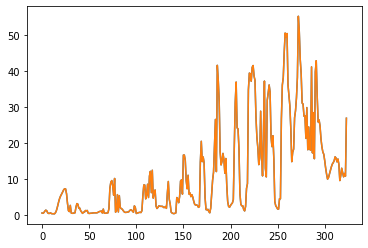

In [124]:
plt.plot(np.diagonal(data['K_den'][100,:,:]))
plt.plot(np.diagonal(data['K_den'][19,:,:]))

In [125]:
diffcov = np.dot(data['diff'].T,data['diff'])/(data['diff'].shape[0]-1)
ratio_og = np.diagonal(diffcov)/np.diagonal(data['K_den'][1000,:,:])
print('median ratio = ' +str(np.median(ratio)))
print('mean ratio = ' + str(np.mean(ratio)))

median ratio = 0.4653961519152424
mean ratio = 0.4863986856793043


In [126]:
#ratio_og = ratio

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ]),
 <a list of 9 Text yticklabel objects>)

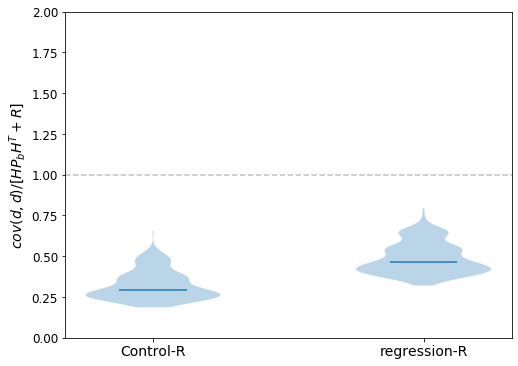

In [127]:
vp_data = [ratio_og,ratio]

fig, ax = plt.subplots(figsize=(8, 6))
plt.axhline(1,linestyle='--', color='gray',zorder=0, alpha=0.5)

vp = ax.violinplot(vp_data,[0,1],showmeans=False,showmedians=True, showextrema=False)

plt.xticks([0,1], labels=['Control-R','regression-R'], 
           fontsize=14)#, rotation=45)
plt.ylim(0,2)

plt.ylabel('$cov(d,d)/[HP_bH^{T}+R]$', fontsize=14)
plt.yticks(fontsize=12)

In [169]:
LIM = oda.load_L('cesm_lme_Amon')
LIMd = LIM['LIMd']
LIMd.keys()

Loading: /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/master/LIMcast_cesm_lme_Amon_ntrain_850_1650_cesm_lme_Amon_validy_1651_1850_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20211202_sqrtWt.pkl


dict_keys(['vec', 'veci', 'val', 'lam_L', 'C_0', 'C_1', 'Gt', 'lam_L_adj', 'npos_eigenvalues', 'E3', 'W_all', 'standard_factor', 'E3_all', 'E_sic', 'var_dict', 'P_train', 'exp_setup', 'frac_neg_eigenvals'])

### Decompress posterior: 

In [277]:
LIMd['E3_all'].shape[0]+LIMd['E_sic'].shape[0], data['Xa'].shape

(35424, (1860, 300))

In [278]:
Xa_dcomp = np.zeros((LIMd['E3_all'].shape[0]+LIMd['E_sic'].shape[0],data['Xa'].shape[0]))
nmodes = LIMd['E3_all'].shape[1]

Xa_dcomp = limkb.decompress_eof_separate_sic(data['Xa'].T,nmodes,LIMd['exp_setup']['nmodes_sic'],
                                             LIMd['E3_all'],LIMd['E_sic'],LIMd['exp_setup']['limvars'],
                                             LIMd['var_dict'],LIMd['W_all'],Weights=LIMd['exp_setup']['Weight'],
                                             sic_separate=LIMd['exp_setup']['sic_separate'])

In [279]:
Xa_dcomp_all = {}

for var in limvars: 
    Xa_dcomp_all[var] = Xa_dcomp[LIMd['var_dict'][var]['var_inds'],:]

In [280]:
Xa_dcomp_all['tas'].shape

(6912, 1860)

## Load Truth: 

In [20]:
mo='all'
#mo=7

# forecast lead time in months that defines the LIM training
tau = 1

#lat_cutoff = 0.1
lat_cutoff_dict = {'tas':0.1,'psl':0.1,'zg':0.1,'tos':0.1,'sit':40,'sic':40}

ntrain = 800
nvalid = 200

# tscut = False     # time start cut 
# tecut = 355       # 800 training years LME
# tecut = 0
# tscut = 800
tecut = None
tscut = 1001

# variables to include in the LIM (note "vars" is a Python command)
#limvars = ['tas','rlut','zg']
#limvars = ['tas','tos','psl','sit','sic']
#limvars = ['tas']
limvars = ['tas','tos','psl','zg','sit','sic']

limvars_nosic = []
nvars = len(limvars)

train_dsource = 'cesm_lme'
valid_dsource = 'cesm_lme_Amon'


sic_separate = True
Insamp = False
dt=True
wt=True

In [21]:
fdic_valid = limkb.build_training_dic(valid_dsource)

full_names, areawt_name, month_names = limbuild.load_full_names(valid_dsource)

In [22]:
var_dict = {}
X_var_all = {}

for k, var in enumerate(limvars): 
    X_var, var_dict = limkb.load_data(var, var_dict, fdic_valid, remove_climo=True, 
                                      detrend=dt, verbose=True, cmip6=False, 
                                      tscut=tscut, tecut=tecut, lat_cutoff=lat_cutoff_dict[var])

    if mo is 'all':
        print('Using month: '+str(mo))
        X_var_in = X_var
    else: 
        print('Using month: '+str(mo))
        tsamp = X_var.shape[1]
        x_var = np.reshape(X_var,(X_var.shape[0],int(tsamp/12),12))[:,:,mo:mo+2]
        X_var_in = np.reshape(x_var, (x_var.shape[0],x_var.shape[1]*x_var.shape[2]))

    if var is 'sic':
        if np.nanmax(X_var)>1:
            print('Changing units of sic be a between 0 to 1')
            X_var_in = X_var_in/100
            
    X_var_all[var] = X_var_in

Loading from tas
Loading from a/LME/LIMs/tas_sfc_Amon_CESM_LMEallforc_002_085001-200512.nc
time dimension: 1851 - 2005
latitude cutoff detected: 0.1
detrending...
Working on month...0
Working on month...1
Working on month...2
Working on month...3
Working on month...4
Working on month...5
Working on month...6
Working on month...7
Working on month...8
Working on month...9
Working on month...10
Working on month...11
-----------------------------------------------------
completed in 6.4256932735443115 seconds
-----------------------------------------------------
Using month: all
Loading from tos
Loading from os_sfc_Omon_CESM_LMEallforc_002_regrid_Amon_085001-200512.nc
time dimension: 1851 - 2005
latitude cutoff detected: 0.1
detrending...
Working on month...0
Found with nans (not in satellite), going to fill with zeros...
Working on month...1
Found with nans (not in satellite), going to fill with zeros...
Working on month...2
Found with nans (not in satellite), going to fill with zeros...


In [246]:
import datetime

nyears = 155

# Generate times: 
t_total = nyears*12
years = int(1851+np.floor((t_total-1)/12))
time = np.array([datetime.datetime(y, m, 15) for y in np.arange(1851,1851+nyears,1) for m in np.arange(1,13,1)])

In [247]:
data['mse_xb'], data['mse_xa']

(array([8.81075086, 2.51796747, 2.05251742, ..., 0.42789865, 1.60244306,
        3.05424461]),
 array([1.44818816, 0.70328967, 0.67696921, ..., 0.19817587, 0.49848918,
        1.17150749]))

## Skill in EOF Space: 

Text(0, 0.5, 'Mean squared error (K$^2$)\n at observation locations')

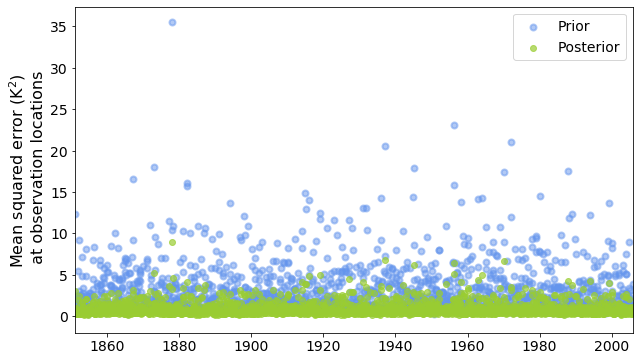

In [281]:
fig = plt.figure(figsize=(10,6))

plt.scatter(time,data['mse_xb'], label='Prior', linewidth=2, color='cornflowerblue', alpha=0.5)
plt.scatter(time,data['mse_xa'], label='Posterior', color='yellowgreen', alpha=0.7)

plt.legend(fontsize=14)
plt.xlim(time[0],time[1859])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel('Mean squared error (K$^2$)\n at observation locations', fontsize=16)

In [57]:
# fig = plt.figure(figsize=(10,6))
# median = np.zeros((time.shape[0]))
# mean = np.zeros((time.shape[0]))

# for t in range(time.shape[0]):
#     median[t] = np.median(data['ratios'][t])
#     mean[t] = np.mean(data['ratios'][t])
    
# plt.scatter(time,mean, label='Mean', linewidth=2, color='cornflowerblue', alpha=0.3)
# plt.scatter(time,median, label='Median', linewidth=2, color='yellowgreen', alpha=0.3)

# plt.axhline(1,color='k', linewidth=4, linestyle='--')
# plt.axhline(np.mean(mean),color='royalblue', linewidth=4, linestyle='-')
# plt.axhline(np.mean(median),color='olivedrab', linewidth=4, linestyle='-')

# plt.legend(fontsize=14)
# plt.xlim(time[0],time[1859])
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.ylabel('cov(d,d)/[HP$_b$H$^T$+R]', fontsize=16)

In [58]:
def calc_tot_si_checks(var, areacell, units, lat, nlon, lat_cutoff=0.0): 
    """Calculates total NH sea ice area. 
    
    INPUTS: 
    var: sea ice concentration (ndof,ntime), (ndarray)
    areacell: grid cell area, 1D or 2D, (ndarray)
    units: string ('km^2' or 'm2')
    lat: 
    lat_cutoff
    
    OUTPUTS: 
    tot_nh_var
    """
    
    if len(areacell.shape)>1:
        areacell_1d = np.reshape(areacell,(areacell.shape[0]*areacell.shape[1]))
    else: 
        areacell_1d = areacell

    if units == 'm2':
        cellarea = (areacell_1d*1e-6)[:,np.newaxis]
    else: 
        cellarea = areacell_1d[:,np.newaxis]

    if len(var.shape)<=1:
        var_3d = np.reshape(var,(lat.shape[0],nlon))
    elif len(var.shape) ==2:     
        var_3d = np.reshape(var,(lat.shape[0],nlon,var.shape[1]))
    else: 
        var_3d = var

    if len(lat.shape)<=1:
        var_nh_3d = var_3d[(lat>0),:,:]
        test_var = var_nh_3d[np.isfinite(var_nh_3d)]
    elif len(lat.shape)>1:
        var_nh_3d = var_3d[(lat>0),:]
        test_var = var_nh_3d[np.isfinite(var_nh_3d)]

    if np.nanmax(test_var)>5:
        print('Max concentration is '+str(np.round(np.nanmax(test_var),2))+
              ' ...dividing concentration by 100.')
        Var = var/100.0
    else: 
        Var = var

    nh_var = Var*cellarea

    if len(lat.shape)<=1:
        if len(var.shape)<=1:
            nh_var_3d = np.reshape(nh_var,(lat.shape[0],nlon))
            lat_inds = np.where(lat>lat_cutoff)
            tot_nh_var = np.nansum(np.nansum(nh_var_3d[lat_inds,:].squeeze(),axis=0),axis=0)
        else:     
            nh_var_3d = np.reshape(nh_var,(lat.shape[0],nlon,var.shape[1]))
            lat_inds = np.where(lat>lat_cutoff)
            tot_nh_var = np.nansum(np.nansum(nh_var_3d[lat_inds,:,:].squeeze(),axis=0),axis=0)
    else:
        lat_1d = np.reshape(lat,(var.shape[0]))
        lat_inds = np.where(lat_1d>lat_cutoff)
        tot_nh_var = np.nansum(nh_var[lat_inds,:].squeeze(),axis=0)
        
    return tot_nh_var

In [59]:
def arctic_mean(var, areacell, cutoff=0.0): 
    if len(areacell.shape)>1:
        areacell_1d = np.reshape(areacell,(areacell.shape[0]*areacell.shape[1]))
    else: 
        areacell_1d = areacell
        
    tot_nh_var = var*areacell_1d
    
    if len(lat.shape)<=1:
        lat_inds = np.where(var_dict[var]['lat']>cutoff)
        tot_nh_var = np.nansum(np.nansum(tot_nh_var[:,lat_inds,:],axis=1),axis=1)
    
        wt_sum = np.nansum(np.nansum(cellarea[lat_inds,:],axis=0),axis=0)
    else:
        lat_inds = np.where(var_dict[var]['lat']>cutoff)
        tot_nh_var = np.nansum(np.nansum(tot_nh_var[:,lat_inds],axis=1),axis=1)
    
        wt_sum = np.nansum(np.nansum(cellarea[lat_inds],axis=0),axis=0)
    
    var_mn = tot_nh_var/wt_sum
    
    return var_mn

In [60]:
def global_mean(var, areacell): 
    """Assumes var is dimensions (nlat*nlon,time)
    """
    var_shape = len(var.shape)
    var_nan_mask = np.where(np.isnan(var),np.nan,1)
    
    if (var_shape<2)&(len(areacell.shape)>1): 
        areacell_1d = np.reshape(areacell,(areacell.shape[0]*areacell.shape[1]))
    elif (var_shape>1)&(len(areacell.shape)>1): 
        areacell_1d_temp = np.reshape(areacell,(areacell.shape[0]*areacell.shape[1]))
        areacell_1d = areacell_1d_temp[:,np.newaxis]
    elif (var_shape>1)&(len(areacell.shape)<=1): 
        areacell_1d = areacell[:,np.newaxis]
    else: 
        areacell_1d = areacell
        
    tot_nh_var = var*areacell_1d
    
    tot_var = np.nansum(tot_nh_var,axis=0)
    wt_sum = np.nansum(areacell_1d*var_nan_mask,axis=0)
    
    var_mn = tot_var/wt_sum
    
    return var_mn

In [61]:
def calc_validataion_stats(var, truth_anom, forecast_anom, var_dict,areacell,areacell_dict,
                           areawt_name,LIMd,lat_cutoff=False,iplot=False):
    """
    """ 
    units = areacell_dict[var][areawt_name[var]]['units']

    if 'km' in units:
        acell = areacell[var]
    elif 'centi' in units: 
        print('changing cellarea units from '+
              str(areacell_dict[var][areawt_name[var]]['units'])+' to km^2')
        acell = areacell[var]*(1e-10)
        units = 'km^2'
    else: 
        print('changing cellarea units from '+
              str(areacell_dict[var][areawt_name[var]]['units'])+' to km^2')
        acell = areacell[var]*(1e-6)
        units = 'km^2'
        
    if var == 'sic':
        nlon = int(var_dict[var]['var_ndof']/var_dict[var]['lat'].shape[0])
        tot_var_forecast = statskb.calc_tot_si_checks(forecast_anom,acell,units,var_dict[var]['lat'],nlon,lat_cutoff=0.0)
        tot_var_truth = statskb.calc_tot_si_checks(truth_anom,acell,units,var_dict[var]['lat'],nlon,lat_cutoff=0.0)
    else: 
        tot_var_forecast = statskb.global_mean(forecast_anom,acell)
        tot_var_truth = statskb.global_mean(truth_anom,acell)
    
    
    if iplot==True: 
        time = var_dict[var]['time']
        ntime = tot_var_truth.shape[0]
        ttime = time.shape[0]
        
        plt.figure(figsize=(6,4))
        plt.plot(tot_var_truth,label='truth')
        plt.plot(tot_var_forecast,label='forecast')
        plt.xlim(0,20)
        plt.legend()
        plt.show()

    corr_tot = np.corrcoef(tot_var_truth,np.nan_to_num(tot_var_forecast))[0,1]
    ce_tot = oda.coefficient_efficiency(tot_var_truth,np.nan_to_num(tot_var_forecast))
    
     ## New error var calculations: 10/06/21
    forecast_nan_mask = np.where(np.isclose(np.nanvar(LIMd['E3'][var],axis=1),0,atol=1e-5),np.nan,1)

    rmse = np.sqrt(np.nanmean((truth_anom-forecast_anom)**2,axis=1))
    gm_rmse = statskb.global_mean(rmse*forecast_nan_mask,acell)
    gsum_rmse = np.nansum(gm_rmse*forecast_nan_mask)
    
    return corr_tot, ce_tot, tot_var_forecast, tot_var_truth, gm_rmse, gsum_rmse, rmse

## Full field: pan-Arctic skill

In [282]:
full_names, areawt_name, month_names = limbuild.load_full_names(valid_dsource)

areacell_dict_all = {}
areacell = {}
for var in limvars:
    areacell_dict = {}
    areacell[var], areacell_dict_all[var] = limkb.load_data(areawt_name[var], areacell_dict, fdic_valid, 
                                                            remove_climo=False, detrend=False, verbose=False, 
                                                            lat_cutoff=LIMd['exp_setup']['lat_cutoff'][var])

Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 0.1
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40
Loading from cuments/SeaIceData/LME/LIMs/areacella_CESM_LME_global_001.nc
latitude cutoff detected: 40


In [283]:
corr_tot = {}
ce_tot = {}
tot_var_forecast = {}
tot_var_truth = {}
gm_rmse = {}
gsum_rmse = {}
rmse = {}

for var in limvars: 
    print('Working on '+var)
    truth_anom = X_var_all[var]
    forecast_anom = Xa_dcomp_all[var]

    [corr_tot[var], ce_tot[var], tot_var_forecast[var], 
     tot_var_truth[var], gm_rmse[var], gsum_rmse[var], 
     rmse[var]]  = calc_validataion_stats(var, truth_anom, forecast_anom, LIMd['var_dict'],
                                     areacell,areacell_dict_all,
                                     areawt_name,LIMd,lat_cutoff=False,iplot=False)

Working on tas
changing cellarea units from m^2 to km^2
Working on tos
changing cellarea units from m^2 to km^2


/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


Working on psl
changing cellarea units from m^2 to km^2
Working on zg
changing cellarea units from m^2 to km^2
Working on sit
changing cellarea units from m^2 to km^2
Working on sic
changing cellarea units from m^2 to km^2


In [284]:
corr_tot['sit']

0.6787288630413086

In [ ]:
fig,axs = plt.subplots(2,3, figsize=(20,9))
ax = axs.flatten()

for i,var in enumerate(limvars):
    if 'sic' in var: 
        truth = tot_var_truth[var]*1e-6
        forecast = tot_var_forecast[var]*1e-6
    else: 
        truth = tot_var_truth[var]
        forecast = tot_var_forecast[var]
        
    lims = np.around(max(np.abs(truth.min()), truth.max()),decimals=2)
    lims = lims + lims/10
    
    ax[i].plot(time, truth, label='Truth',color='k', linewidth=1)
    ax[i].plot(time, forecast, label='Reconstruction', color='royalblue')
#    ax[i].plot(time, truth, label='Truth',color='cornflowerblue', linewidth=2)
    ax[i].text(time[80],(-lims+ lims/15),'R$^2$ = '+str(np.round(corr_tot[var]**2,2))+', CE = '+str(np.round(ce_tot[var],2)),
              fontsize=14, color='royalblue', fontweight='bold')

    ax[i].set_title(var, fontsize=16)
    ax[i].grid()
    ax[i].set_xlim(time[0],time[-1])
    ax[i].set_ylim(-lims,lims)
#     ax[i].xticks(fontsize=14)
#     ax[i].yticks(fontsize=14)

ax[4].legend(fontsize=14)
ax[0].set_ylabel('Northern hemisphere mean', fontsize=14)
ax[3].set_ylabel('Northern hemisphere mean', fontsize=14)

Text(0, 0.5, 'Northern hemisphere mean')

Text(0, 0.5, 'Northern hemisphere mean')

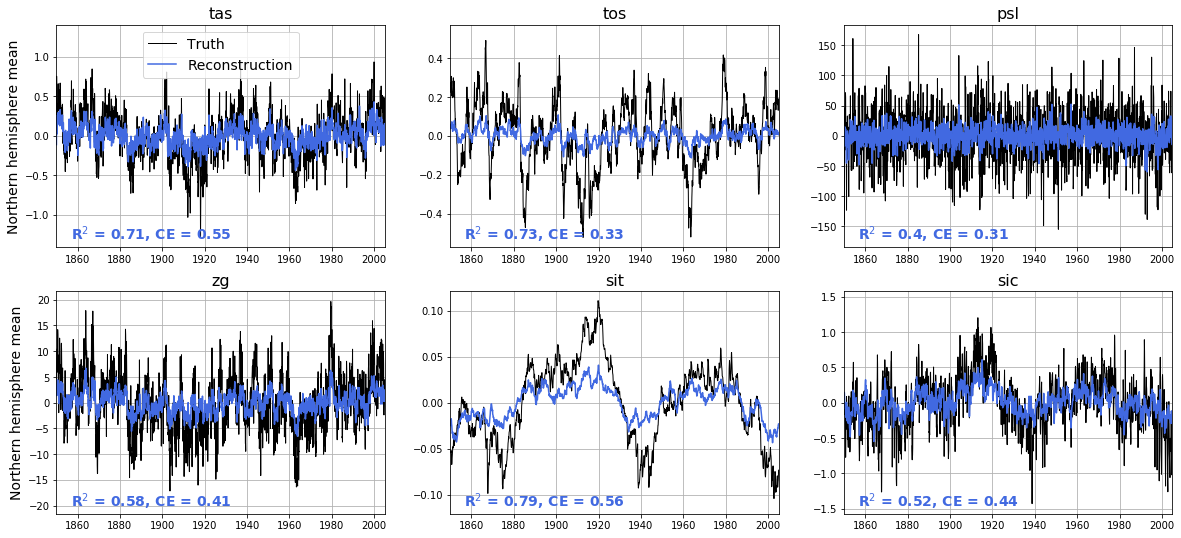

In [92]:
fig,axs = plt.subplots(2,3, figsize=(20,9))
ax = axs.flatten()

for i,var in enumerate(limvars):
    if 'sic' in var: 
        truth = tot_var_truth[var]*1e-6
        forecast = tot_var_forecast[var]*1e-6
    else: 
        truth = tot_var_truth[var]
        forecast = tot_var_forecast[var]
        
    lims = np.around(max(np.abs(truth.min()), truth.max()),decimals=2)
    lims = lims + lims/10
    
    ax[i].plot(time, truth, label='Truth',color='k', linewidth=1)
    ax[i].plot(time, forecast, label='Reconstruction', color='royalblue')
#    ax[i].plot(time, truth, label='Truth',color='cornflowerblue', linewidth=2)
    ax[i].text(time[80],(-lims+ lims/15),'R$^2$ = '+str(np.round(corr_tot[var]**2,2))+', CE = '+str(np.round(ce_tot[var],2)),
              fontsize=14, color='royalblue', fontweight='bold')

    ax[i].set_title(var, fontsize=16)
    ax[i].grid()
    ax[i].set_xlim(time[0],time[-1])
    ax[i].set_ylim(-lims,lims)
#     ax[i].xticks(fontsize=14)
#     ax[i].yticks(fontsize=14)

ax[0].legend(fontsize=14)
ax[0].set_ylabel('Northern hemisphere mean', fontsize=14)
ax[3].set_ylabel('Northern hemisphere mean', fontsize=14)

## Full field: Spatial skill: 

In [38]:
corr_all = {}
ce_all = {}

for var in limvars: 
    corr_var = np.zeros((Xa_dcomp_all[var].shape[0]))
    ce_var = np.zeros((Xa_dcomp_all[var].shape[0]))

    for i in range(Xa_dcomp_all[var].shape[0]):
        corr_var[i] = np.corrcoef(X_var_all[var][i,:],Xa_dcomp_all[var][i,:])[0,1]
        ce_var[i] = oda.coefficient_efficiency(X_var_all[var][i,:],Xa_dcomp_all[var][i,:])

    corr_var_2d = np.reshape(corr_var,(LIMd['var_dict'][var]['lat'].shape[0],LIMd['var_dict'][var]['lon'].shape[0]))
    ce_var_2d = np.reshape(ce_var,(LIMd['var_dict'][var]['lat'].shape[0],LIMd['var_dict'][var]['lon'].shape[0]))
    
    corr_all[var] = corr_var_2d
    ce_all[var] = ce_var_2d

../Online_DA_utils.py:98: RuntimeWarning: Mean of empty slice
  denom = np.nansum(np.power(ref-np.nanmean(ref,axis=0),2),axis=0)
../Online_DA_utils.py:99: RuntimeWarning: invalid value encountered in true_divide
  CE    = 1. - np.divide(numer,denom)
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
../Online_DA_utils.py:99: RuntimeWarning: divide by zero encountered in true_divide
  CE    = 1. - np.divide(numer,denom)


In [39]:
from cartopy.util import add_cyclic_point

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)


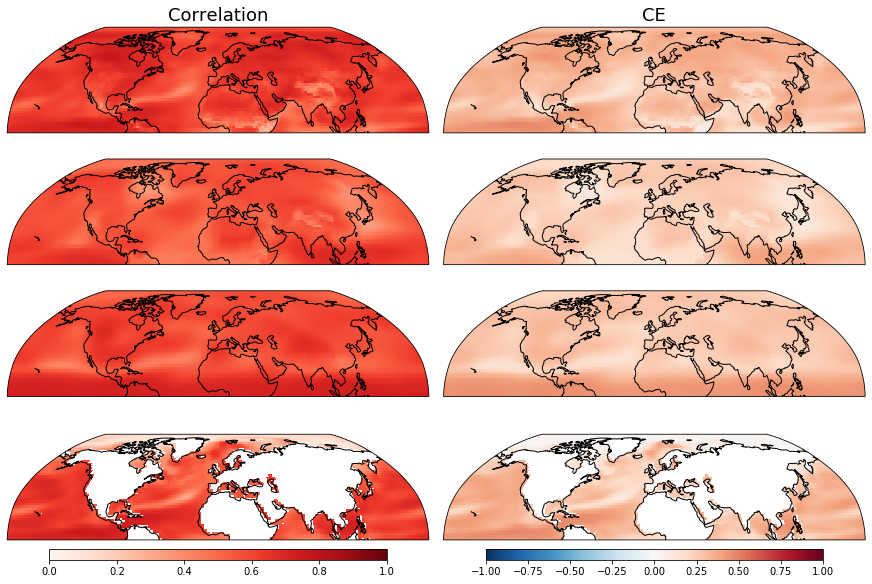

In [40]:
#fig = plt.figure(2, figsize=(14, 18))
fig,axs = plt.subplots(4,2, figsize=(12, 8), constrained_layout=True,
                       subplot_kw={'projection':ccrs.Robinson()})
ax = axs.flatten()
pltv = np.arange(0,8,2)

for v,var in enumerate(['tas','psl','zg','tos']): 
    lat = LIMd['var_dict'][var]['lat']
    lon = LIMd['var_dict'][var]['lon']
    
    wrap_corr, wrap_lon = add_cyclic_point(corr_all[var], coord=lon)
    wrap_ce, wrap_lon = add_cyclic_point(ce_all[var], coord=lon)
    
    i = pltv[v]
    ax[i].coastlines()
    cb1 = ax[i].pcolormesh(wrap_lon,lat,wrap_corr,#corr_all[var],
                           cmap='Reds',transform=ccrs.PlateCarree(),
                           vmin=0, vmax=1)

    ax[i+1].coastlines()
    cb2 = ax[i+1].pcolormesh(wrap_lon,lat,wrap_ce,
                   cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-1, vmax=1)

ax[0].set_title('Correlation', fontsize=18)
ax[1].set_title('CE', fontsize=18)

plt.colorbar(cb1, orientation='horizontal', shrink=0.8, ax=ax[6])
plt.colorbar(cb2, orientation='horizontal', shrink=0.8, ax=ax[7])

plt.tight_layout()

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)


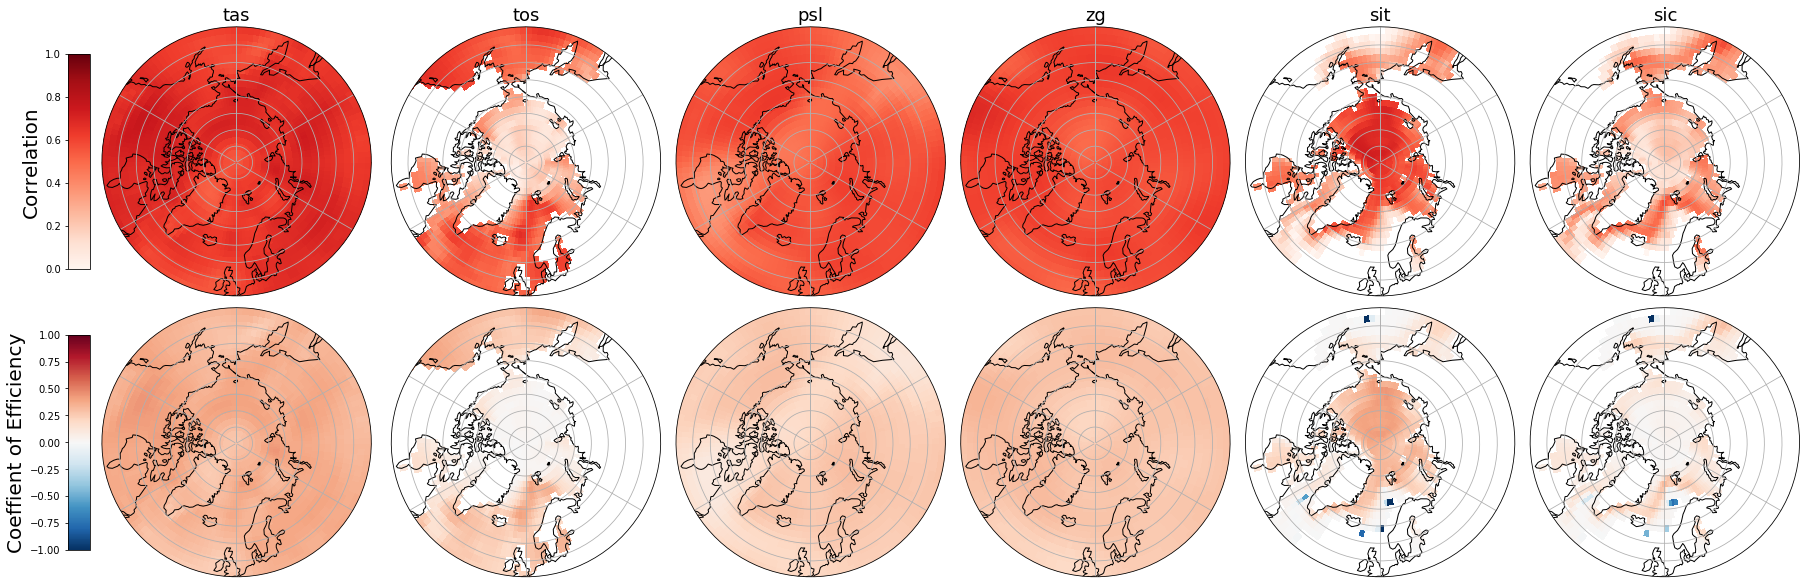

In [41]:
#fig = plt.figure(2, figsize=(14, 18))
fig,axs = plt.subplots(2,6, figsize=(25,8),constrained_layout=True,
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax = axs.flatten()
pltv = np.arange(6,12,1)

for v,var in enumerate(limvars):
    lat = LIMd['var_dict'][var]['lat']
    lon = LIMd['var_dict'][var]['lon']
    
    wrap_corr, wrap_lon = add_cyclic_point(corr_all[var], coord=lon)
    wrap_ce, wrap_lon = add_cyclic_point(ce_all[var], coord=lon)
    
    ax[v].coastlines()
    ax[v].gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[v].set_boundary(circle, transform=ax[v].transAxes)
    ax[v].set_extent([-180, 180, 90, 50], crs=ccrs.PlateCarree())
    cb1 = ax[v].pcolormesh(wrap_lon,lat,wrap_corr,
                           cmap='Reds',transform=ccrs.PlateCarree(),
                           vmin=0, vmax=1)
    i = pltv[v]
    ax[i].coastlines()
    ax[i].gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 90, 50], crs=ccrs.PlateCarree())
    cb2 = ax[i].pcolormesh(wrap_lon,lat,wrap_ce,
                           cmap='RdBu_r',transform=ccrs.PlateCarree(),
                           vmin=-1, vmax=1)
    
    ax[v].set_title(var, fontsize=18)


colb1 = fig.colorbar(cb1, location='left',shrink=0.8, ax=ax[0],aspect=30)
colb2 = plt.colorbar(cb2, location='left',shrink=0.8, ax=ax[6],aspect=30)

colb1.set_label(label='Correlation', size=20)
colb2.set_label(label='Coeffient of Efficiency', size=20)

plt.tight_layout()

/home/disk/chaos/mkb22/anaconda2/envs/lims_update/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)


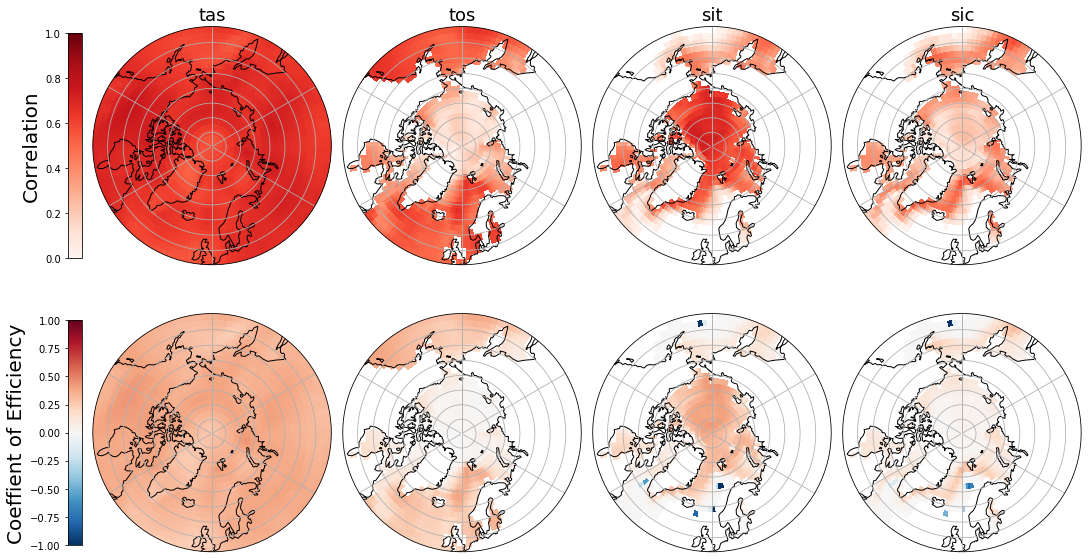

In [42]:
#fig = plt.figure(2, figsize=(14, 18))
fig,axs = plt.subplots(2,4, figsize=(15,8), constrained_layout=True,
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax = axs.flatten()
pltv = np.arange(4,8,1)

for v,var in enumerate(['tas','tos','sit','sic']):
    lat = LIMd['var_dict'][var]['lat']
    lon = LIMd['var_dict'][var]['lon']
    
    wrap_corr, wrap_lon = add_cyclic_point(corr_all[var], coord=lon)
    wrap_ce, wrap_lon = add_cyclic_point(ce_all[var], coord=lon)
    
    ax[v].coastlines()
    ax[v].gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[v].set_boundary(circle, transform=ax[v].transAxes)
    ax[v].set_extent([-180, 180, 90, 50], crs=ccrs.PlateCarree())
    cb1 = ax[v].pcolormesh(wrap_lon,lat,wrap_corr,
                           cmap='Reds',transform=ccrs.PlateCarree(),
                           vmin=0, vmax=1)
    i = pltv[v]
    ax[i].coastlines()
    ax[i].gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax[i].set_boundary(circle, transform=ax[i].transAxes)
    ax[i].set_extent([-180, 180, 90, 50], crs=ccrs.PlateCarree())
    cb2 = ax[i].pcolormesh(wrap_lon,lat,wrap_ce,
                           cmap='RdBu_r',transform=ccrs.PlateCarree(),
                           vmin=-1, vmax=1)
    
    ax[v].set_title(var, fontsize=18)


ax[0].set_ylabel('Correlation', fontsize=18)
# ax[1].set_title('CE', fontsize=18)

colb1 = fig.colorbar(cb1, location='left',shrink=0.8, ax=ax[0],aspect=30)
colb2 = plt.colorbar(cb2, location='left',shrink=0.8, ax=ax[4],aspect=30)

colb1.set_label(label='Correlation', size=20)
colb2.set_label(label='Coeffient of Efficiency', size=20)
#plt.tight_layout()